# Depression prediction 

Regarding severity, PHQ-9 comprises five categories, where a cut-off point of 0–4 indicates no depressive symptoms, 5–9 mild depressive symptoms, 10–14 moderate depressive symptoms, 15–19 moderately-severe depressive symptoms, and 20–27 severe depressive symptoms 

link to search variables: https://wwwn.cdc.gov/nchs/nhanes/search/default.aspx

# 3. Prepare and explore the data

##  3.1 Merge data 

In [1]:
import sklearn 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
from functools import reduce
import os
from dmba import classificationSummary
%matplotlib inline

no display found. Using non-interactive Agg backend


In [2]:
#not including medications
os.chdir('/Users/beiw/Google Drive/PHS@UChicago/2021 Autumn/data mining/project/data')
files= ['demographic.csv', 'diet.csv', 'questionnaire.csv'] #only use demo, diet, and questionnaire 
demo= pd.read_csv('demographic.csv')
diet= pd.read_csv('diet.csv')
exam= pd.read_csv('examination.csv')
lab= pd.read_csv('labs.csv')
med= pd.read_csv('medications.csv')
qr= pd.read_csv('questionnaire.csv')

In [3]:
print('demo', demo.shape)
print('diet', diet.shape)
print('exam', exam.shape)
print('lab', lab.shape)
print('med', med.shape)
print('ques', qr.shape)

demo (10175, 47)
diet (9813, 168)
exam (9813, 224)
lab (9813, 424)
med (20194, 13)
ques (10175, 953)


In [4]:
ls=[]
for file in files: 
    df= pd.read_csv(file)
    ls.append(df)
df_merge= reduce(lambda x,y: pd.merge(x, y,  how='inner', on= 'SEQN', suffixes=('', '_drop')), ls)
df_merge.drop([col for col in df_merge.columns if 'drop' in col], axis=1, inplace=True)
print("merged df shape:", df_merge.shape)

merged df shape: (9813, 1166)


In [5]:
#check for duplicated SEQN
df_merge.SEQN.duplicated().value_counts()

False    9813
Name: SEQN, dtype: int64

### Get codebook for the dataset: for meaning of features
This was done in a seperate files; some of the variables names are inconsistent, resulting in NaN, so I changed them manually. 

In [6]:
cbook= pd.read_csv('nhanes_2013_2014_codebook.csv')

## 3.2 Missingness 
Missing data in the dataset are all represented in 7s and 9s. We drop observations that have missing data in the target variable (phq9), which results in 3657 unique observations. Among the rest of the features, we drop those with more than 20% missing data or those are non-numeric, which results in 502 features. Within the dataset that has minimized missingness, we further prepare the data set by imputing the rest of the missingness using the most_frequent method in each column. 

In [7]:
#replace all 7s and 9s as null 
df_merge.replace({7:None, 9:None, 77:None,99:None,777:None,999:None,7777:None,9999:None,77777:None,99999:None,
            777777:None,999999:None,55:None,555:None,5555:None,8:None,88:None}, inplace=True)

### Drop observations with missingness in target feature
The target feature is PHQ9, which consists of 10 features from DPQ010 to DPQ100.

In [8]:
#test
df_merge.DPQ050.describe

<bound method NDFrame.describe of 0       0.0
1       0.0
2       0.0
3       NaN
4       3.0
       ... 
9808    0.0
9809    NaN
9810    NaN
9811    NaN
9812    NaN
Name: DPQ050, Length: 9813, dtype: float64>

In [9]:
#create phq9 scores and drop rows with any item missing 
df_merge['phq9']= df_merge[['DPQ010','DPQ020','DPQ030','DPQ040', 'DPQ050', 'DPQ060', 'DPQ070', 'DPQ080', 'DPQ090', 'DPQ100']].sum(axis=1, skipna=False)
df_merge= df_merge[df_merge['phq9'].notna()]
print(df_merge.shape)

(3657, 1167)


In [10]:
df_merge.phq9.describe()

count    3657.000000
mean        5.202625
std         4.997506
min         1.000000
25%         2.000000
50%         3.000000
75%         7.000000
max        30.000000
Name: phq9, dtype: float64

### Drop feature columns with more than 20% missing data 

In [11]:
#drop columns with more than no missing data
df_merge= df_merge.dropna(thresh= 0.8*len(df_merge), axis=1)

### Drop non-numeric columns

In [12]:
# exclude non-numeric values
df_merge = df_merge.select_dtypes(['number'])
print(len(df_merge.columns), 'columns left')

292 columns left


In [13]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3657 entries, 0 to 9805
Columns: 292 entries, SEQN to phq9
dtypes: float64(279), int64(13)
memory usage: 8.2 MB


### Impute missing values 

In [14]:
#imputation 
from sklearn.impute import SimpleImputer
imp_mode=SimpleImputer(strategy='most_frequent')

df_merge = pd.DataFrame(imp_mode.fit_transform(df_merge), columns=df_merge.columns)
#could try other imputation method KNN

## 3.3 Target features (PHQ9) visualization

The target feature was looked at in a few different ways: 

#### PHQ9 itself is a numeric feature with a possible range from 0 to 30

#### PHQ9 was dichotomized in the follow ways according to exisitng literature  

* Mild depression: phq9>=5

* Moderate depression: phq9>=15  

* Severe depression: phq9>=20 

#### Suicidal ideation was added as a potential target

* Suicidal ideation: DPQ090 >0


#### Numeric PHQ9 

(array([1866.,  800.,  411.,  236.,  135.,   93.,   63.,   32.,   16.,
           5.]),
 array([ 1. ,  3.9,  6.8,  9.7, 12.6, 15.5, 18.4, 21.3, 24.2, 27.1, 30. ]),
 <BarContainer object of 10 artists>)

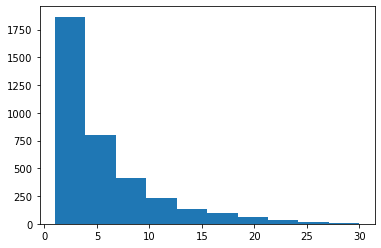

In [15]:
plt.hist(df_merge.phq9)

#### Mild depression

In [16]:
df_merge['mild_dep']= np.where(df_merge['phq9']>=5,1,0)
print('mild', df_merge['mild_dep'].value_counts())

mild 0    2228
1    1429
Name: mild_dep, dtype: int64


(array([2228.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1429.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

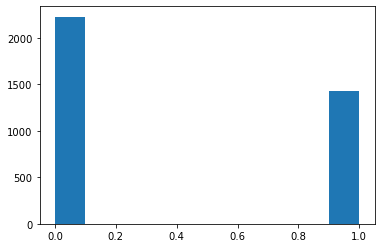

In [17]:
plt.hist(df_merge.mild_dep)

#### Moderate depression

In [18]:
df_merge['mod_dep']= np.where(df_merge['phq9']>=15,1,0)
print('modereate', df_merge['mod_dep'].value_counts())

modereate 0    3402
1     255
Name: mod_dep, dtype: int64


(array([3402.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         255.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

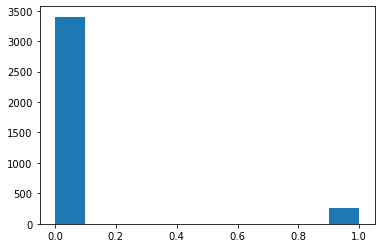

In [19]:
plt.hist(df_merge.mod_dep)

#### Severe depression

In [20]:
df_merge['sev_dep']= np.where(df_merge['phq9']>=20,1,0)
print('severe', df_merge['sev_dep'].value_counts())

severe 0    3564
1      93
Name: sev_dep, dtype: int64


(array([3564.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          93.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

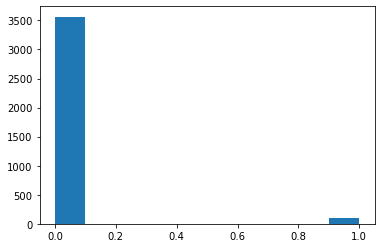

In [21]:
plt.hist(df_merge.sev_dep)

#### Suicidal ideation

In [22]:
df_merge['suicidal']= np.where(df_merge['DPQ090']>0,1,0)
print('suicidal', df_merge['suicidal'].value_counts())

suicidal 0    3474
1     183
Name: suicidal, dtype: int64


(array([3474.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         183.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

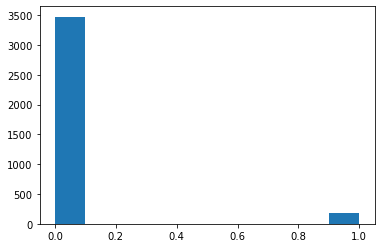

In [23]:
plt.hist(df_merge.suicidal)

## 3.4 Other key features exploration
We explored other key demographic features to describe this population. 

* A large proportion of the population is non-Hispanic white while there are also Hispanics, non-Hispanic blacks, and non-Hispanic Asians. 

* People's age ranges from 18 to 80 with larger proportions of the youngest and the oldest group. 

* There are more females than males. This population is also highly educated. About a quarter of the population was not US-born. 

*note: could some visualization of depression outcomes by these features*

### Race and ethnicity 
1(Mexican American), 2(Other Hispanic); 3(non-H white); 4(non-H black); 6(non-H Asian)

https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/DEMO_H.htm


(array([ 489.,    0.,  333.,    0., 1772.,    0.,  712.,    0.,    0.,
         351.]),
 array([1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ]),
 <BarContainer object of 10 artists>)

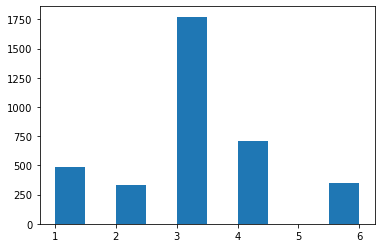

In [24]:
plt.hist(df_merge.RIDRETH3)

### Age

(array([569., 336., 346., 349., 328., 318., 355., 373., 264., 419.]),
 array([18. , 24.2, 30.4, 36.6, 42.8, 49. , 55.2, 61.4, 67.6, 73.8, 80. ]),
 <BarContainer object of 10 artists>)

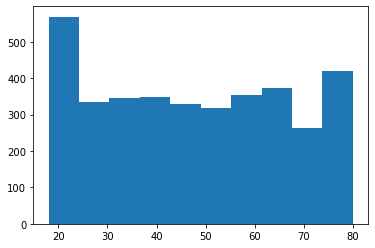

In [25]:
plt.hist(df_merge.RIDAGEYR)

In [26]:
df_merge.RIDAGEYR.describe()

count    3657.000000
mean       47.581624
std        19.245747
min        18.000000
25%        31.000000
50%        47.000000
75%        64.000000
max        80.000000
Name: RIDAGEYR, dtype: float64

### Gender (1: male; 2: female)

(array([1582.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        2075.]),
 array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ]),
 <BarContainer object of 10 artists>)

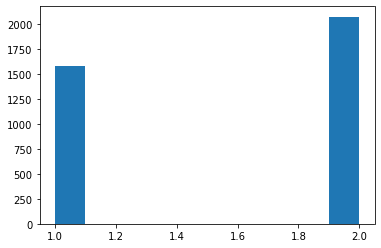

In [27]:
plt.hist(df_merge.RIAGENDR)

### Education attainment 
1(less than high school); 2(some high school); 3(high school graduate/GED or equivalent); 4(some college or AA degree); 5(college graduate or above)

(array([ 225.,    0.,  478.,    0.,    0.,  807.,    0., 1335.,    0.,
         812.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

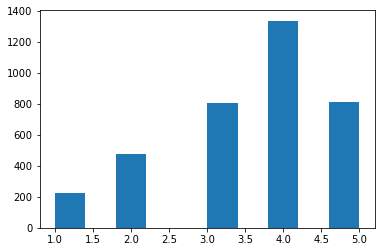

In [28]:
plt.hist(df_merge.DMDEDUC2)

### Country of birth (1: born in the US; 2: not born in the US)

(array([2749.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         908.]),
 array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ]),
 <BarContainer object of 10 artists>)

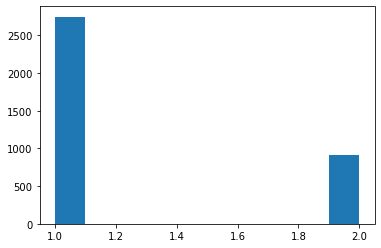

In [29]:
plt.hist(df_merge.DMDBORN4)

## 3.5 Feature selection (feature importance)

### Create a function for normalize data 

In [30]:
from sklearn.preprocessing import StandardScaler 
def normalize_data(X): 
    X_std= pd.DataFrame(StandardScaler().fit_transform(X))
    X_std.columns= X.columns
    return X_std

### Linear regression using phq9 as a numeric target

Coefficients of regressions can be used directly as some crude type of feature importance score. So I'm starting with regression models and use their coefficients for insights on feature selection.

This is an overfitting and naiive model that I use to get some sense of the top ranked coefficients for feature selection.

In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
#partition into X and y
target=['phq9']
drop_features= ['phq9',
                'SEQN',
                'DPQ010', 'DPQ020', 'DPQ030', 'DPQ040', 'DPQ050', 'DPQ060','DPQ070','DPQ080', 'DPQ090', 'DPQ100',
               'mild_dep', 'mod_dep', 'sev_dep', 'suicidal']
X = df_merge[df_merge.columns.drop(drop_features)]
y= df_merge[target]
X_scaled= normalize_data(X)
y_scaled= normalize_data(y)
# #normalize data
# X_scaled= normalize_data(X)
# y_scaled= normalize_data(y)
# #training and validation sets split based on normalized data
train_X, valid_X, train_y, valid_y = train_test_split(X_scaled, y_scaled, test_size=0.4, random_state=42)
print('Training_X: ', train_X.shape)
print('Validation_X: ', valid_X.shape)
print('Training_y: ', train_y.shape)
print('Validation_y: ', valid_y.shape)
lr=LinearRegression()
lr.fit(train_X, train_y)

Training_X:  (2194, 280)
Validation_X:  (1463, 280)
Training_y:  (2194, 1)
Validation_y:  (1463, 1)


LinearRegression()

In [32]:
importance= lr.coef_
importance= importance.flatten()
columns= df_merge.columns
df = pd.DataFrame({'feature': train_X.columns, 'importance': importance})
df = df.sort_values('importance', ascending=False)

In [33]:
#select top 30 features 
df30= df[:30]
df30.columns=['variable', 'importance']
df30['variable'] = df30['variable'].apply(lambda x: x.upper())
df30 = pd.merge(left=df30, right=cbook, left_on='variable', right_on='variable', how='left')

<ipython-input-33-d343ccd9b52f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df30['variable'] = df30['variable'].apply(lambda x: x.upper())


In [34]:
df30

,variable,importance,label
0,DRABF,1.124152e+13,Breast-fed infant (either day)
1,MIAPROXY,1.416622e+12,Proxy used in MEC Interview?
2,HSAQUEX,1.954397e+11,Source of Health Status Data
3,DR1.320Z,1.781679e+00,NaN
4,DR1TPFAT,1.101523e+00,Total polyunsaturated fatty acids (gm)
5,DR1TCARB,7.129679e-01,Carbohydrate (gm)
6,WTINT2YR,5.791300e-01,Full sample 2 year interview weight
7,DR1TSFAT,5.093896e-01,Total saturated fatty acids (gm)
8,DR1TPROT,3.597458e-01,Protein (gm)
9,DR1TRET,2.826115e-01,Retinol (mcg)


### Logistic regression: moderate depression
This is an overfitting and naiive model that I use to get some sense of the top ranked coefficients for feature selection.

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from matplotlib import pyplot
#partition into X and y
target=['mod_dep']
drop_features= ['phq9',
                'SEQN',
                'DPQ010', 'DPQ020', 'DPQ030', 'DPQ040', 'DPQ050', 'DPQ060','DPQ070','DPQ080', 'DPQ090', 'DPQ100',
               'mild_dep', 'sev_dep', 'suicidal', 'mod_dep']
X = df_merge[df_merge.columns.drop(drop_features)]
y= df_merge[target]
X_scaled= normalize_data(X)
# training and validation sets split, predictors are scaled
train_X, valid_X, train_y, valid_y = train_test_split(X_scaled, y, test_size=0.4, random_state=42, stratify=y)
print('Training_X: ', train_X.shape)
print('Validation_X: ', valid_X.shape)
print('Training_y: ', train_y.shape)
print('Validation_y: ', valid_y.shape)

#fit the model 
logit=LogisticRegression()
logit.fit(train_X, train_y)

Training_X:  (2194, 280)
Validation_X:  (1463, 280)
Training_y:  (2194, 1)
Validation_y:  (1463, 1)


/Users/beiw/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/beiw/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [36]:
importance= logit.coef_
importance= importance.flatten()
columns= df_merge.columns
df = pd.DataFrame({'feature': train_X.columns, 'importance': importance})
df = df.sort_values('importance', ascending=False)

In [37]:
#select top 30 features 
df30= df[:30]
df30.columns=['variable', 'importance']
df30['variable'] = df30['variable'].apply(lambda x: x.upper())
df30 = pd.merge(left=df30, right=cbook, left_on='variable', right_on='variable', how='left')

<ipython-input-37-d343ccd9b52f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df30['variable'] = df30['variable'].apply(lambda x: x.upper())


In [38]:
df30

,variable,importance,label
0,HSD010,0.788445,General health condition
1,WTDRD1,0.716010,Dietary day one sample weight
2,DR1TSELE,0.582252,Selenium (mcg)
3,DR1TZINC,0.552436,Zinc (mg)
4,DR1TMOIS,0.533266,Moisture (gm)
5,HEQ030,0.517417,Ever told you have Hepatitis C?
6,MCQ082,0.516062,Ever been told you have celiac disease?
7,FSD032A,0.516050,HH Worried run out of food
8,PFQ054,0.502239,Need special equipment to walk
9,DR1TSFAT,0.496148,Total saturated fatty acids (gm)


#### Performance in the test set
The accuracy of the overfitting model is not bad as expected. The actual and predicted 1 are unreasonably small. This might be because of the imbalanced dataset we have. So we will need to balance the sample with sampling techniques. 

In [39]:
classificationSummary(valid_y, logit.predict(valid_X))

Confusion Matrix (Accuracy 0.9057)

       Prediction
Actual    0    1
     0 1301   60
     1   78   24


### note: 
*we could replicate this on suicidal ideation*

*we need to balance sampling at some point*

*we could rank the abosulte values for linear regression*


### Decision tree classification: moderate depression

In [40]:
from sklearn.tree import DecisionTreeClassifier
from matplotlib import pyplot
tree= DecisionTreeClassifier()
tree.fit(train_X, train_y)
importance= tree.feature_importances_
importance= importance.flatten()
columns= df_merge.columns
df = pd.DataFrame({'feature': train_X.columns, 'importance': importance})
df = df.sort_values('importance', ascending=False)

In [41]:
#select top 30 features 
df30= df[:30]
df30.columns=['variable', 'importance']
df30['variable'] = df30['variable'].apply(lambda x: x.upper())
df30 = pd.merge(left=df30, right=cbook, left_on='variable', right_on='variable', how='left')

<ipython-input-41-d343ccd9b52f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df30['variable'] = df30['variable'].apply(lambda x: x.upper())


In [42]:
df30

,variable,importance,label
0,HSD010,0.079946,General health condition
1,DLQ040,0.046876,Have serious difficulty concentrating ?
2,DR1TFIBE,0.041821,Dietary fiber (gm)
3,MCQ300C,0.028039,NaN
4,WTDR2D,0.027921,Dietary two-day sample weight
5,ALQ101,0.023754,Had at least 12 alcohol drinks/1 yr?
6,DR1TIRON,0.022105,Iron (mg)
7,PAD680,0.021869,Minutes sedentary activity
8,DR1TCHL,0.021412,Total choline (mg)
9,PFQ049,0.021047,Limitations keeping you from working


### Random forest feature selection: moderate depression

In [43]:
from sklearn.ensemble import RandomForestClassifier
forest= RandomForestClassifier()
forest.fit(train_X, train_y)
importance= forest.feature_importances_
importance= importance.flatten()
columns= df_merge.columns
df = pd.DataFrame({'feature': train_X.columns, 'importance': importance})
df = df.sort_values('importance', ascending=False)

<ipython-input-43-29a88de639b7>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest.fit(train_X, train_y)


In [44]:
#select top 30 features 
df30= df[:30]
df30.columns=['variable', 'importance']
df30['variable'] = df30['variable'].apply(lambda x: x.upper())
df30 = pd.merge(left=df30, right=cbook, left_on='variable', right_on='variable', how='left')

<ipython-input-44-d343ccd9b52f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df30['variable'] = df30['variable'].apply(lambda x: x.upper())


In [45]:
df30

,variable,importance,label
0,HUQ010,0.019234,General health condition
1,HSD010,0.019095,General health condition
2,PFQ057,0.016077,Experience confusion/memory problems
3,DLQ040,0.013739,Have serious difficulty concentrating ?
4,WHD020,0.012034,Current self-reported weight (pounds)
5,DR1TSUGR,0.010764,Total sugars (gm)
6,WTINT2YR,0.010746,Full sample 2 year interview weight
7,PFQ049,0.010745,Limitations keeping you from working
8,DR1TFDFE,0.010178,"Folate, DFE (mcg)"
9,WTMEC2YR,0.010039,Full sample 2 year MEC exam weight


### XGboost for feature selection

In [46]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
xgboost = XGBClassifier()
xgboost.fit(train_X, train_y)
importance= xgboost.feature_importances_
columns= df_merge.columns
df = pd.DataFrame({'feature': train_X.columns, 'importance': importance})
df = df.sort_values('importance', ascending=False)

/Users/beiw/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/beiw/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[09:25:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [47]:
#select top 30 features 
df30= df[:30]
df30.columns=['variable', 'importance']
df30['variable'] = df30['variable'].apply(lambda x: x.upper())
df30 = pd.merge(left=df30, right=cbook, left_on='variable', right_on='variable', how='left')

<ipython-input-47-d343ccd9b52f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df30['variable'] = df30['variable'].apply(lambda x: x.upper())


In [48]:
df30

,variable,importance,label
0,MCQ203,0.032410,Ever been told you have jaundice?
1,DIQ180,0.024421,Had blood tested past three years
2,PFQ049,0.024374,Limitations keeping you from working
3,INQ090,0.023546,Income from Supplemental Security Income
4,SXD021,0.020442,"Ever had vaginal, anal, or oral sex"
5,DLQ040,0.016088,Have serious difficulty concentrating ?
6,MCQ053,0.014161,Taking treatment for anemia/past 3 mos
7,DR1TPROT,0.013444,Protein (gm)
8,MCQ300C,0.013102,NaN
9,HUQ010,0.012820,General health condition


In [49]:
#confusion matrix
classificationSummary(valid_y, xgboost.predict(valid_X))

Confusion Matrix (Accuracy 0.9262)

       Prediction
Actual    0    1
     0 1347   14
     1   94    8


## 3.6 Oversampling using synthetic minority over-sampling technique (SMOTE) 
A problem with imbalanced classification is that there are too few examples of the minority class for a model to effectively learn the decision boundary. One way to solve this problem is to oversample the examples in the minority class. SMOTE works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line. Specifically, a random example from the minority class is first chosen. Then k of the nearest neighbors for that example are found (typically k=5). A randomly selected neighbor is chosen and a synthetic example is created at a randomly selected point between the two examples in feature space. (https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/)

In [50]:
import imblearn
from collections import Counter
from sklearn.datasets import make_classification
print(imblearn.__version__)

0.8.1


In [51]:
#recreate X,y for moderate depression
target=['mod_dep']
drop_features= ['phq9',
                'SEQN',
                'DPQ010', 'DPQ020', 'DPQ030', 'DPQ040', 'DPQ050', 'DPQ060','DPQ070','DPQ080', 'DPQ090', 'DPQ100',
               'mild_dep', 'sev_dep', 'suicidal', 'mod_dep']
X = df_merge[df_merge.columns.drop(drop_features)]
y= df_merge[target]

In [52]:
y.value_counts()

mod_dep
0          3402
1           255
dtype: int64

### The combination of SMOTE and under-sampling (to trim the number of examples in the majority class) performs bettern than plain under-sampling (https://arxiv.org/abs/1106.1813)

In [53]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [54]:
#oversample the minority class to have 30% the number of examples of the majority class
over = SMOTE(sampling_strategy=0.3)
#reduce the number of examples in the majority class to have 50% more than the minority class
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

In [55]:
X, y=pipeline.fit_resample(X, y)

In [56]:
y.value_counts()

mod_dep
0          2040
1          1020
dtype: int64

### Re-run feature selection using the more balanced data 

In [57]:
X_scaled= normalize_data(X)
# training and validation sets split, predictors are scaled
train_X, valid_X, train_y, valid_y = train_test_split(X_scaled, y, test_size=0.4, random_state=42, stratify=y)
print('Training_X: ', train_X.shape)
print('Validation_X: ', valid_X.shape)
print('Training_y: ', train_y.shape)
print('Validation_y: ', valid_y.shape)

Training_X:  (1836, 280)
Validation_X:  (1224, 280)
Training_y:  (1836, 1)
Validation_y:  (1224, 1)


In [58]:
xgboost.fit(train_X, train_y)
importance= xgboost.feature_importances_
columns= df_merge.columns
df = pd.DataFrame({'feature': train_X.columns, 'importance': importance})
df = df.sort_values('importance', ascending=False)
#select top 20 features 
df20= df[:20]
df20.columns=['variable', 'importance']
df20['variable'] = df20['variable'].apply(lambda x: x.upper())
df20 = pd.merge(left=df20, right=cbook, left_on='variable', right_on='variable', how='left')

[09:25:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/beiw/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/beiw/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
<ipython-input-58-1ac33277e18d>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

In [59]:
df20

,variable,importance,label
0,PFQ049,0.139191,Limitations keeping you from working
1,HSQ520,0.045024,"SP have flu, pneumonia, ear infection?"
2,PFQ051,0.036570,Limited in amount of work you can do
3,HSD010,0.025326,General health condition
4,DLQ040,0.024613,Have serious difficulty concentrating ?
5,INQ020,0.024356,Income from wages/salaries
6,HUQ010,0.023286,General health condition
7,SLQ060,0.020664,Ever told by doctor have sleep disorder?
8,MCQ300B,0.015472,NaN
9,FSDHH,0.014184,Household food security category


### The classification results are more reasonable after balancing data

In [60]:
classificationSummary(valid_y, xgboost.predict(valid_X))

Confusion Matrix (Accuracy 0.9338)

       Prediction
Actual   0   1
     0 788  28
     1  53 355


## 3.7 Selected variables and correlation matrix 

In [61]:
var_list= df20.variable.tolist()
var_list.append('mod_dep')
print(var_list)

['PFQ049', 'HSQ520', 'PFQ051', 'HSD010', 'DLQ040', 'INQ020', 'HUQ010', 'SLQ060', 'MCQ300B', 'FSDHH', 'DLQ080', 'PFQ057', 'SMQ856', 'FSDAD', 'SMQ870', 'MCQ080', 'MCQ365D', 'DR1TSELE', 'HIQ011', 'MCQ053', 'mod_dep']


In [62]:
#final df
y_final= y.filter(var_list)
X_final= X.filter(var_list)

In [63]:
X_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3060 entries, 0 to 3059
Data columns (total 20 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   PFQ049    3060 non-null   float64
 1   HSQ520    3060 non-null   float64
 2   PFQ051    3060 non-null   float64
 3   HSD010    3060 non-null   float64
 4   DLQ040    3060 non-null   float64
 5   INQ020    3060 non-null   float64
 6   HUQ010    3060 non-null   float64
 7   SLQ060    3060 non-null   float64
 8   MCQ300B   3060 non-null   float64
 9   FSDHH     3060 non-null   float64
 10  DLQ080    3060 non-null   float64
 11  PFQ057    3060 non-null   float64
 12  SMQ856    3060 non-null   float64
 13  FSDAD     3060 non-null   float64
 14  SMQ870    3060 non-null   float64
 15  MCQ080    3060 non-null   float64
 16  MCQ365D   3060 non-null   float64
 17  DR1TSELE  3060 non-null   float64
 18  HIQ011    3060 non-null   float64
 19  MCQ053    3060 non-null   float64
dtypes: float64(20)
memory usage: 4

<AxesSubplot:>

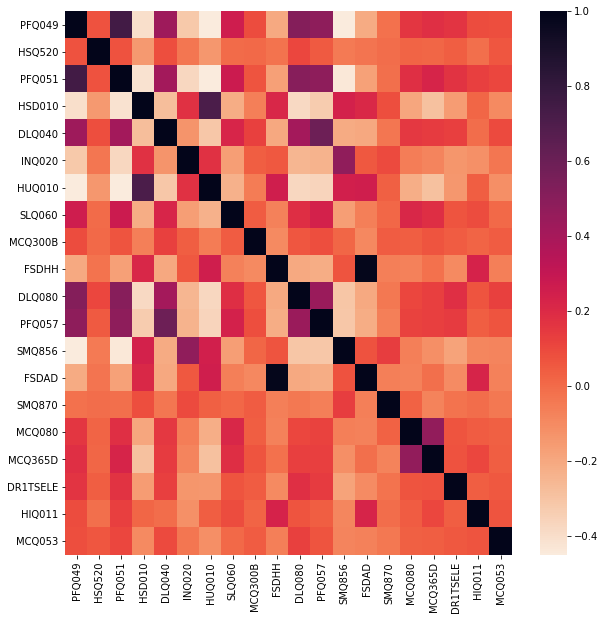

In [64]:
ax=plt.subplots(figsize=(10,10))
corr=X_final.corr()
sns.heatmap(corr, cmap=sns.cm.rocket_r)

In [65]:
#get highly correlated pairs, ranked by absolute correlation values 
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

In [66]:
get_top_abs_correlations(X_final, 10)

FSDHH   FSDAD      0.987901
PFQ049  PFQ051     0.746637
HSD010  HUQ010     0.714833
DLQ040  PFQ057     0.596463
PFQ049  DLQ080     0.516978
PFQ051  DLQ080     0.504094
PFQ049  PFQ057     0.484363
PFQ051  PFQ057     0.481912
INQ020  SMQ856     0.478354
MCQ080  MCQ365D    0.469357
dtype: float64

### Narrowed down to 20 predictors; some of them are correlated but we can drop later.

In [67]:
X_final.shape

(3060, 20)

note: 
delete general health duplicate 


# 4. Shortlist promising models 

In [68]:
#final dataset (after balancing and feature selection)
train_X, valid_X, train_y, valid_y = train_test_split(X_final, y_final, test_size=0.4, random_state=42, stratify=y)
print('Training_X: ', train_X.shape)
print('Validation_X: ', valid_X.shape)
print('Training_y: ', train_y.shape)
print('Validation_y: ', valid_y.shape)

Training_X:  (1836, 20)
Validation_X:  (1224, 20)
Training_y:  (1836, 1)
Validation_y:  (1224, 1)


## 4.1 Baseline model: logistic regression 

In [69]:
logit=LogisticRegression()
logit.fit(train_X, train_y)

/Users/beiw/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/beiw/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [70]:
coef= logit.coef_
coef= coef.flatten()
columns= train_X.columns
df = pd.DataFrame({'feature': columns, 
                   'coefficients': coef})
df = df.sort_values('coefficients', ascending=False)
df.columns=['variable', 'coefficients']
df['variable'] = df['variable'].apply(lambda x: x.upper())
df = pd.merge(left=df, right=cbook, left_on='variable', right_on='variable', how='left')

In [71]:
df

,variable,coefficients,label
0,HSD010,0.589439,General health condition
1,FSDAD,0.560819,Adult food security category
2,HIQ011,0.539325,Covered by health insurance
3,MCQ053,0.391264,Taking treatment for anemia/past 3 mos
4,HUQ010,0.367484,General health condition
5,SMQ856,0.143682,Last 7-d worked at job not at home?
6,SMQ870,0.122946,Last 7-d rode in a car?
7,PFQ051,0.002001,Limited in amount of work you can do
8,DR1TSELE,-0.001838,Selenium (mcg)
9,INQ020,-0.021071,Income from wages/salaries


In [72]:
from sklearn.model_selection import KFold, cross_val_score
from numpy import mean
from numpy import std
#cross-validation 
cv = KFold(n_splits=10, random_state=1, shuffle=True)
# evaluate model
scores = cross_val_score(logit, train_X,train_y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.797 (0.023)


In [73]:
import statsmodels.api as sm
logit= sm.Logit(train_y, train_X).fit()
logit.summary()

Optimization terminated successfully.
         Current function value: 0.431236
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                mod_dep   No. Observations:                 1836
Model:                          Logit   Df Residuals:                     1816
Method:                           MLE   Df Model:                           19
Date:                Tue, 30 Nov 2021   Pseudo R-squ.:                  0.3225
Time:                        09:25:10   Log-Likelihood:                -791.75
converged:                       True   LL-Null:                       -1168.6
Covariance Type:            nonrobust   LLR p-value:                1.410e-147
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
PFQ049        -0.7908      0.213     -3.717      0.000      -1.208      -0.374
HSQ520        -0.3092      0.254     -1.218      0.223      -0.807       0.188
PFQ051        -0.0129      0.213     -0.061      0.952      -0.430       0.404
HSD010         0.6337      0.095      6.671      0.000       0.448       0.820
DLQ040        -1.0916      0.183     -5.970      0.000      -1.450      -0.733
INQ020        -0.0521      0.168     -0.311      0.756      -0.380       0.276
HUQ010         0.3617      0.090      4.007      0.000       0.185       0.539
SLQ060        -0.4364      0.167     -2.620      0.009      -0.763      -0.110
MCQ300B       -0.1444      0.152     -0.951      0.342      -0.442       0.153
FSDHH         -0.5023      0.361     -1.393      0.164      -1.209       0.204
DLQ080        -0.2845      0.210     -1.356      0.175      -0.696       0.127
PFQ057        -0.1104      0.203     -0.543      0.587      -0.509       0.288
SMQ856         0.2037      0.160      1.273      0.203      -0.110       0.517
FSDAD          0.7629      0.353      2.163      0.031       0.072       1.454
SMQ870         0.1555      0.172      0.905      0.365      -0.181       0.492
MCQ080        -0.0205      0.150     -0.137      0.891      -0.314       0.273
MCQ365D       -0.5287      0.153     -3.447      0.001      -0.829      -0.228
DR1TSELE      -0.0018      0.001     -1.734      0.083      -0.004       0.000
HIQ011         0.6656      0.166      3.999      0.000       0.339       0.992
MCQ053         0.4412      0.260      1.697      0.090      -0.068       0.951
==============================================================================
"""

note: add p values

## Cross-validation steps
https://machinelearningmastery.com/how-to-configure-k-fold-cross-validation/
cross-validation steps: first 3 steps are done using the training set; the test set will be held out till the end
1. training dataset is used to train a few candidate models 
2. validation dataset is used to evaluate the candidate models
3. one of the candidates is chosen
4. the chosen model is trained with a new training dataset
5. the trained model is evaluated with the test dataset

## 4.2 Decision tree classifier

In [74]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,RandomizedSearchCV 

param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': list(range(2,10)), 
    'min_samples_split': list(range(2,6))
}

gridSearch = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, 
                          n_jobs=-1)
gridSearch.fit(train_X, train_y)
print('initial score: ', gridSearch.best_score_)
print('parameters: ', gridSearch.best_params_)

bestClassTree = gridSearch.best_estimator_

initial score:  0.881249259566402
parameters:  {'criterion': 'gini', 'max_depth': 9, 'min_samples_split': 5, 'splitter': 'best'}


In [75]:
#cross-validation using training set
cv = KFold(n_splits=10, random_state=1, shuffle=True)
# evaluate model
scores = cross_val_score(bestClassTree, train_X,train_y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.879 (0.024)


## 4.3 Nearest neighbor

In [77]:
# from sklearn.neighbors import NearestNeighbors

# param_grid = {
#     'n_neighbors': list(range(2,7)),
#     'radius': [1, 1.2, 1.5, 2],
#     'leaf_size': [25,30, 35] 
# }

# gridSearch = GridSearchCV(NearestNeighbors(), param_grid, cv=5, 
#                           n_jobs=-1)
# gridSearch.fit(train_X, train_y)
# print('initial score: ', gridSearch.best_score_)
# print('parameters: ', gridSearch.best_params_)

# bestClassTree = gridSearch.best_estimator_

## 4.4 SMV classification

In [78]:
from sklearn.svm import LinearSVC
from scipy.stats import uniform

param_grid = {
    'penalty': ['l1', 'l2'],
    'loss': ['hinge', 'squared_hinge'],
    'C': [1, 1.2, 1.5, 2]
}

gridSearch = GridSearchCV(LinearSVC(random_state=42), param_grid, cv=5, 
                          n_jobs=-1)
gridSearch.fit(train_X, train_y)
print('initial score: ', gridSearch.best_score_)
print('parameters: ', gridSearch.best_params_)

bestClassTree = gridSearch.best_estimator_

initial score:  0.7685093590806776
parameters:  {'C': 1.5, 'loss': 'squared_hinge', 'penalty': 'l2'}


/Users/beiw/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.73694023        nan 0.70148827        nan 0.68408956
        nan 0.74017           nan 0.60355852        nan 0.76850936
        nan 0.63499585        nan 0.68536311]
  warnings.warn(
/Users/beiw/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/beiw/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [79]:
#cross-validation using training set
cv = KFold(n_splits=10, random_state=1, shuffle=True)
# evaluate model
scores = cross_val_score(bestClassTree, train_X,train_y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.672 (0.159)


## 4.5 ensemble: random forest classificaion

In [80]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,RandomizedSearchCV 

param_grid = {
    'max_leaf_nodes': list(range(2, 100)),
    'min_samples_split': [4,5,7,9]
}
gridSearch = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, 
                          n_jobs=-1)
gridSearch.fit(train_X, train_y)
print('initial score: ', gridSearch.best_score_)
print('parameters: ', gridSearch.best_params_)

bestClassTree = gridSearch.best_estimator_

initial score:  0.9172136002843265
parameters:  {'max_leaf_nodes': 99, 'min_samples_split': 7}


/Users/beiw/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


In [81]:
#cross-validation using training set
cv = KFold(n_splits=10, random_state=1, shuffle=True)
# evaluate model
scores = cross_val_score(bestClassTree, train_X,train_y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.916 (0.031)


next steps: 
1.classification tree 
2.

## 4.6 ensemble: boosting/bagging 